# Energy consuption time series

A time series is a sequence of numerical data points in successive order. These points are often measured at regular intervals (every month, every day, every hour, etc.). The data frequency used in this article is hourly and it was measured from 2004–10–01 to 2018–08–03. The total number of raw data points is 121271.

In [1]:
# Loading pandas
import pandas as pd

# Loading date wrangling package
from datetime import datetime

# Package for directories
import os

# Reading the input data
d = pd.read_csv(f'{os.getcwd()}/time-series/DAYTON_hourly.csv')

# Formating to datetime
d['Datetime'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in d['Datetime']]

# Making sure there are no duplicated data
# If there are some duplicates we average the data during those duplicated days
d = d.groupby('Datetime', as_index=False)['DAYTON_MW'].mean()

# Sorting the values
d.sort_values('Datetime', inplace=True)

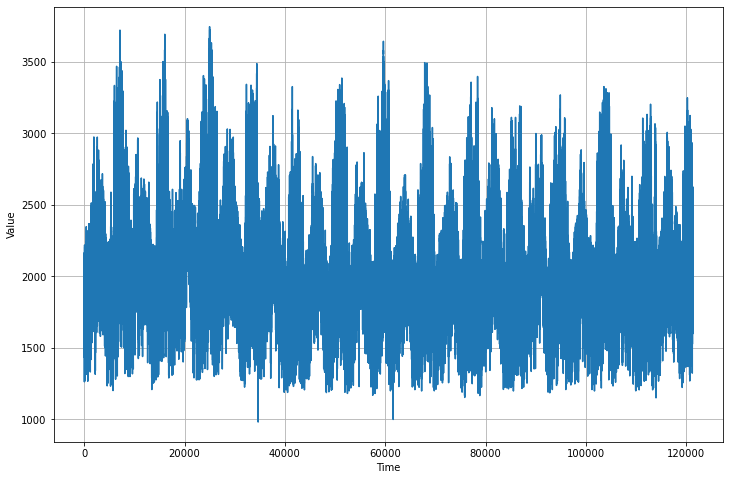

In [2]:
# Ploting the time series 
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    
time = range(d.shape[0])
series = d['DAYTON_MW'].tolist()

plt.figure(figsize=(12, 8))
plot_series(time, series)

# Creating X and Y matrices 

In [3]:
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """
    A method to create a tidy data frame for deep learning
    """
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [4]:
# Defining the spliting hyperparameters
split_time = round(len(series)*0.9)

# Converting to array
time = np.array(time)
series = np.array(series)

time_train = time[:split_time]
y_train = series[:split_time]
time_valid = time[split_time:]
y_valid = series[split_time:]

window_size = 48
batch_size = 64
shuffle_buffer_size = 1000

In [5]:
train = windowed_dataset(y_train, window_size, batch_size, shuffle_buffer_size)
validation = windowed_dataset(y_valid, window_size, batch_size, shuffle_buffer_size)

# Training the model

In [6]:
epochs = 10
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=16, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(8, activation="relu"),
  tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.Huber(),
              optimizer='Adam',
              metrics=["mae"])
history = model.fit(train, epochs=epochs)

Epoch 1/10
1705/1705 [==============================] - 48s 28ms/step - loss: 740.8631 - mae: 741.4722
Epoch 2/10
1705/1705 [==============================] - 42s 25ms/step - loss: 313.9932 - mae: 314.4636
Epoch 3/10
1705/1705 [==============================] - 41s 24ms/step - loss: 277.8833 - mae: 278.3529
Epoch 4/10
1705/1705 [==============================] - 41s 24ms/step - loss: 208.1879 - mae: 208.6774
Epoch 5/10
1705/1705 [==============================] - 41s 24ms/step - loss: 132.4681 - mae: 132.9405
Epoch 6/10
1705/1705 [==============================] - 41s 24ms/step - loss: 61.2991 - mae: 61.7894
Epoch 7/10
1705/1705 [==============================] - 40s 24ms/step - loss: 46.9978 - mae: 47.4898
Epoch 8/10
1705/1705 [==============================] - 43s 25ms/step - loss: 41.8824 - mae: 42.3746
Epoch 9/10
1705/1705 [==============================] - 41s 24ms/step - loss: 39.6962 - mae: 40.1889
Epoch 10/10
1705/1705 [==============================] - 41s 24ms/step - loss: 39

# Ploting the predictions

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

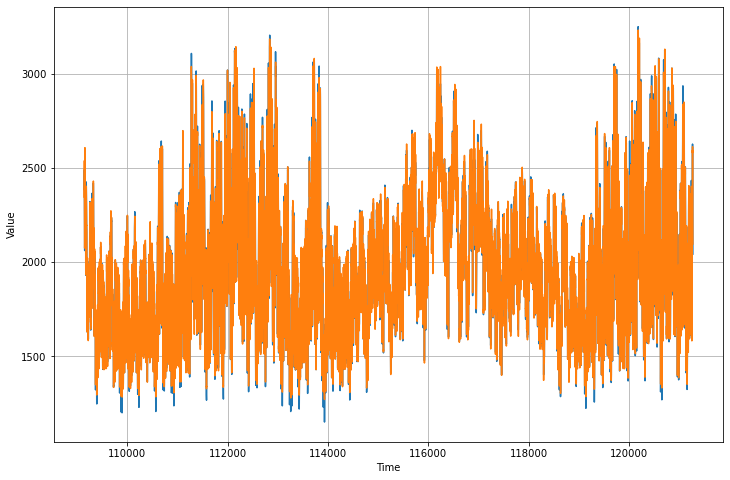

In [9]:
plt.figure(figsize=(12, 8))
plot_series(time_valid, y_valid)
plot_series(time_valid, rnn_forecast)

In [10]:
tf.keras.metrics.mean_absolute_error(y_valid, rnn_forecast).numpy()

30.847801